In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [4]:
# Load dataset
file_path = "../Data Arduino 4 treatment/fixed_formatData.xlsx"
data = pd.read_excel(file_path)

In [5]:
data

,R,G,B,IR_Intensity (%),Perlakuan,Pengambilan
0,151,149.0,106.40,73,0,1
1,151,149.0,109.78,73,0,1
2,149,149.0,106.40,73,0,1
3,149,149.0,130.06,73,0,1
4,149,151.4,106.40,73,0,1
...,...,...,...,...,...,...
1436,147,151.4,136.82,64,3,4
1437,149,153.8,140.20,64,3,4
1438,147,153.8,113.16,64,3,4
1439,149,153.8,123.30,64,3,4


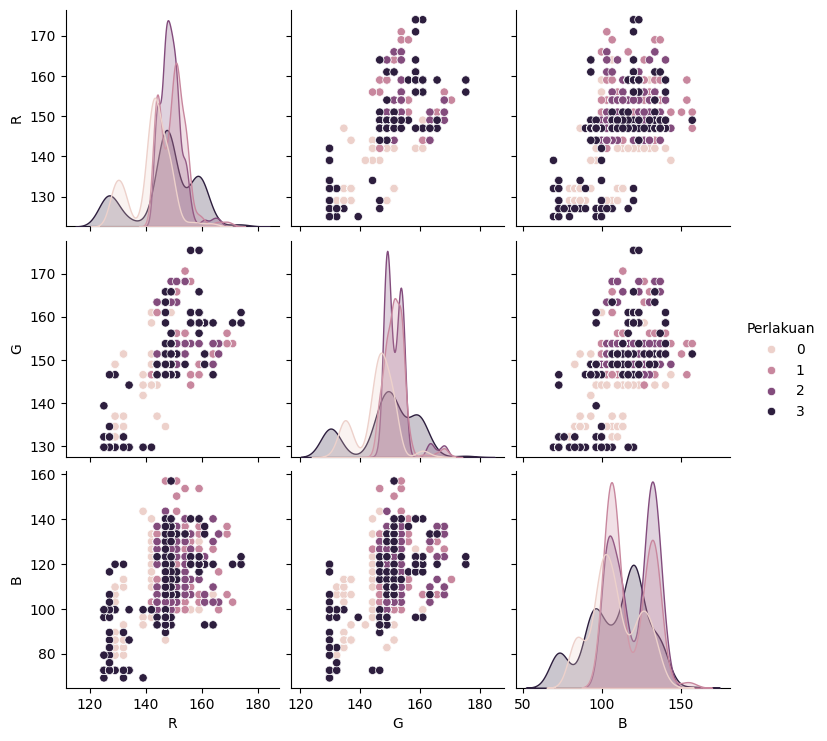

In [6]:
# Visualisasi korelasi
sns.pairplot(data, hue='Perlakuan', vars=['R', 'G', 'B'])
plt.show()

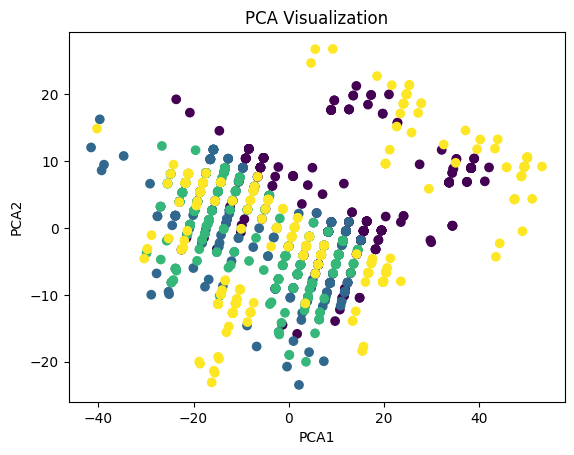

In [7]:
# PCA untuk visualisasi 2D
X = data[['R', 'G', 'B']]
y = data['Perlakuan']
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("PCA Visualization")
plt.show()

In [ ]:
# Uji linearitas dengan Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(multi_class='ovr', max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))

In [1]:
import numpy as np
import skfuzzy as fuzz

# Data (contoh RGB)
data = np.array([[147, 149, 114], [150, 148, 116], [146, 151, 113]])

# Transpose data (format FCM membutuhkan fitur sebagai baris)
data = data.T

# Jumlah cluster (kelas)
n_clusters = 4

# FCM
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    data, c=n_clusters, m=2, error=0.005, maxiter=1000, init=None
)

# Keanggotaan fuzzy
u = u.T

# Prediksi kelas
predicted_classes = np.argmax(u, axis=1)
print(predicted_classes)

[3 2 0]


In [2]:
data

array([[147, 150, 146],
       [149, 148, 151],
       [114, 116, 113]])

In [3]:
u

array([[1.15042215e-31, 1.15042215e-31, 4.93038066e-32, 1.00000000e+00],
       [4.93038066e-32, 4.93038066e-32, 1.00000000e+00, 1.19737816e-31],
       [5.00000000e-01, 5.00000000e-01, 2.46519033e-32, 1.39694119e-31]])

In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

# Data (contoh RGB dengan label kelas)
X_train = np.array([[147, 149, 114], [150, 148, 116], [146, 151, 113]])
y_train = np.array([0, 1, 0])  # Kelas 0 dan 1
X_test = np.array([[148, 150, 115]])

# Normalisasi data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fuzzy KNN parameters
k = 3  # Jumlah tetangga
m = 2  # Fuzziness parameter

def fuzzy_knn(X_train, y_train, X_test, k, m):
    predictions = []
    for x in X_test:
        # Hitung jarak ke setiap data
        distances = np.linalg.norm(X_train - x, axis=1)
        sorted_indices = np.argsort(distances)[:k]  # Ambil k tetangga terdekat

        # Hitung keanggotaan fuzzy untuk setiap kelas
        classes = np.unique(y_train)
        memberships = {c: 0 for c in classes}
        for c in classes:
            for i in sorted_indices:
                if y_train[i] == c:
                    d = distances[i]
                    memberships[c] += 1 / (d ** (2 / (m - 1)) if d != 0 else 1e-10)

        # Normalisasi keanggotaan
        total_membership = sum(memberships.values())
        memberships = {c: memberships[c] / total_membership for c in memberships}

        # Tentukan kelas dengan keanggotaan tertinggi
        predicted_class = max(memberships, key=memberships.get)
        predictions.append(predicted_class)

    return np.array(predictions)

# Prediksi
y_pred = fuzzy_knn(X_train, y_train, X_test, k, m)
print("Predicted Class:", y_pred)

Predicted Class: [0]


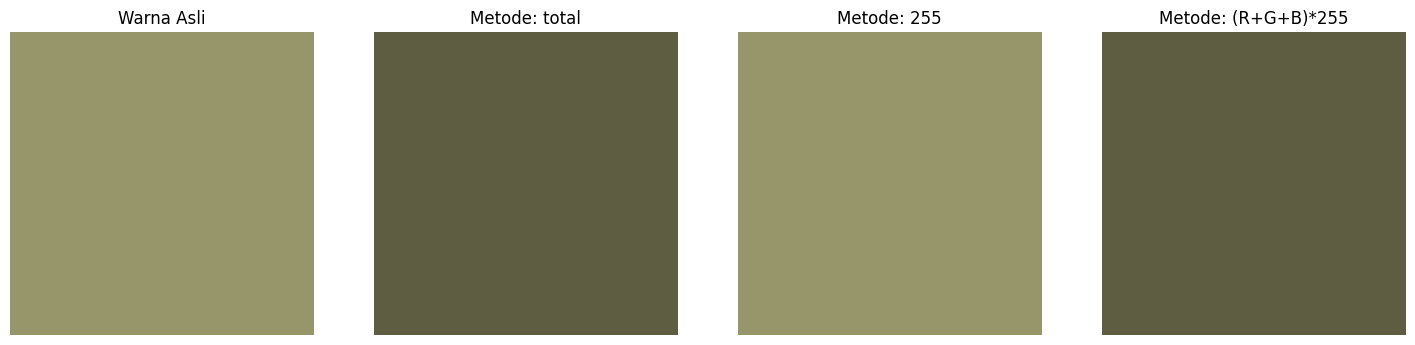

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def normalisasi_rgb(rgb, metode):
    R, G, B = rgb
    if metode == "total":
        total = R + G + B
        return (R / total, G / total, B / total)
    elif metode == "255":
        return (R / 255, G / 255, B / 255)
    elif metode == "(R+G+B)*255":
        total = R + G + B
        # Normalisasi dulu dengan total, kemudian kalikan dengan 255
        if total == 0:
            return (0, 0, 0)  # Menghindari pembagian dengan nol jika R, G, dan B semuanya 0
        return (R / total, G / total, B / total)

def tampilkan_warna(rgb):
    fig, axes = plt.subplots(1, 4, figsize=(18, 4))  # 5 gambar: asli dan 4 normalisasi
    metode_list = ["total", "255", "(R+G+B)*255"]
    
    # Menampilkan warna asli
    axes[0].imshow([[rgb]])
    axes[0].axis('off')
    axes[0].set_title("Warna Asli")
    
    for i, metode in enumerate(metode_list):
        normalized_rgb = normalisasi_rgb(rgb, metode)
        
        # Clipping values to ensure they are in the [0, 1] range for imshow
        normalized_rgb = np.clip(normalized_rgb, 0, 1)
        
        axes[i+1].imshow([[normalized_rgb]])
        axes[i+1].axis('off')
        axes[i+1].set_title(f"Metode: {metode}")
    
    plt.show()

# Contoh nilai RGB
rgb_value = (151, 149, 106)
tampilkan_warna(rgb_value)
